In [1]:
# Import Dependencies

import pandas as pd
import numpy as np
from fbprophet import Prophet
import requests
from pprint import pprint
from datetime import datetime, timedelta
from bs4 import BeautifulSoup as bs
from sqlalchemy import create_engine
import psycopg2


/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning:

The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.



In [2]:
# AWS Server Details

server= "bootcampdb.cmwhqarpyd9v.ca-central-1.rds.amazonaws.com"
database = "postgres"
port ="5432"
username = "root"
password = "xy92Hdie"

conn = f"postgres://{username}:{password}@{server}:{port}/{database}"

In [3]:
# Read Bitcoin daily data from Alpha Vantage API

av_api_key = 'IYOYBP274BRSLPM0'

url = "https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=CAD&apikey={av_api_key}"

data = requests.get(url).json()
bc_data = data["Time Series (Digital Currency Daily)"]

In [4]:
# Loop through json response API data and transform into lists in python to create pandas dataframe

date = []
open_CAD = []
open_USD = []
high_CAD = []
high_USD = []
low_CAD = []
low_USD = []
close_CAD = []
close_USD = []
volume = []

date = list(bc_data.keys())

for d in date:
  value = bc_data[d]
  close_CAD.append(value['4a. close (CAD)'])
  close_USD.append(value['4b. close (USD)'])
  volume.append(value['5. volume'])
  open_CAD.append(value['1a. open (CAD)'])
  open_USD.append(value['1b. open (USD)'])
  high_CAD.append(value['2a. high (CAD)'])
  high_USD.append(value['2b. high (USD)'])
  low_CAD.append(value['3a. low (CAD)'])
  low_USD.append(value['3b. low (USD)'])

In [5]:
# Create Pandas dataframe

df = pd.DataFrame({"Date": date, "Open_USD": open_USD, "High_USD": high_USD,  "Low_USD": low_USD,  "Close_USD":close_USD, "Volume": volume})
df.head()




,Date,Open_USD,High_USD,Low_USD,Close_USD,Volume
0,2021-03-21,58100.02000000,58589.10000000,57811.41000000,58390.00000000,2104.04540700
1,2021-03-20,58030.01000000,59880.00000000,57820.17000000,58102.28000000,44476.94177600
2,2021-03-19,57641.00000000,59468.00000000,56270.74000000,58030.01000000,52392.65296100
3,2021-03-18,58912.97000000,60129.97000000,57023.00000000,57648.16000000,66580.40667500
4,2021-03-17,56900.74000000,58974.73000000,54123.69000000,58912.97000000,70421.62084100


In [6]:
engine = create_engine(conn, echo=False)

In [7]:
df.to_sql("coin_price", con=engine, if_exists = 'replace', index=False, method='multi')

with engine.connect() as con:
    con.execute('ALTER TABLE "coin_price" ADD PRIMARY KEY ("Date");')

In [8]:
# Read Bitcoin crypto rating data from Alpha Vantage API


# crypto_rating_url = 'https://www.alphavantage.co/query?function=CRYPTO_RATING&symbol=BTC&apikey={av_api_key}'

# rating_data = requests.get(crypto_rating_url).json()

# rating = rating_data['Crypto Rating (FCAS)']['3. fcas rating']
# score = rating_data['Crypto Rating (FCAS)']['4. fcas score']
# refresh_date = rating_data['Crypto Rating (FCAS)']['8. last refreshed']


In [9]:
# Create a pandas df

# rating_df = pd.DataFrame({"Date": refresh_date, "Rank": rating, "Score": score}, index=[0])
# rating_df['Date'] = pd.to_datetime(rating_df['Date'], infer_datetime_format=True)
# rating_df['Date'] = rating_df['Date'].dt.strftime('%Y-%m-%d')

# rating_df 

In [10]:
# engine = create_engine(conn, echo=False)

In [11]:
# rating_df.to_sql("rating", con=engine, if_exists = 'replace', index=False)

# with engine.connect() as con:
#     con.execute('ALTER TABLE "rating" ADD PRIMARY KEY ("Date");')

In [12]:
# Coin Market Cap URL of page to be scraped for Market Cap data

cmc_url = 'https://coinmarketcap.com/'

# Retrieve page with the requests module

response = requests.get(cmc_url)

# Create BeautifulSoup object; parse with 'html.parser'

soup = bs(response.text, 'html.parser')

In [13]:
#Scrape url for the data

results = soup.find_all('div', class_='sc-33i2yg-0 dOnegn')

for r in results:
  header = r.find_all('span', class_="sc-12ja2s9-0 eALoKW")
   
  title =[]
  value =[]
  for values in header:
    data = (values.text.split(":"))
    title.append(data[0])

    if data[0] == "Dominance":
      value.append(data[2][1:5])
    else:
      value.append(data[1][2:])



In [14]:
# create data table in pandas and clean up data

market_cap_df = pd.DataFrame({"Title": title, "Value": value})
market_cap_df = market_cap_df.drop(index=5)
market_cap_df = market_cap_df.transpose()
columns = market_cap_df.iloc[0].values
market_cap_df.columns = columns
market_cap_df.drop('Title', axis=0, inplace = True)
market_cap_df.reset_index(inplace=True)
market_cap_df = market_cap_df.drop(columns='index')
market_cap_df = market_cap_df.rename(columns={"Dominance": "BTC_Dominance", "Market Cap": "Total_Market_Cap", "24h Vol": "24h_Volume"})
market_cap_df['Total_Market_Cap'] = market_cap_df['Total_Market_Cap'].str.replace("$","")
market_cap_df['24h_Volume'] = market_cap_df['24h_Volume'].str.replace("$","")
market_cap_df = market_cap_df.replace(',','', regex=True)
market_cap_df

,Cryptocurrencies,Markets,Total_Market_Cap,24h_Volume,BTC_Dominance
0,8901,36584,1779441037853,118880189300,60.2


In [15]:
market_cap_df['BTC_Market_Cap_T'] = market_cap_df['Total_Market_Cap'].astype(float)*(market_cap_df['BTC_Dominance'].astype(float)/100)
market_cap_df['BTC_Market_Cap_T']= round((market_cap_df['BTC_Market_Cap_T']/1000000000000),2)
market_cap_df

,Cryptocurrencies,Markets,Total_Market_Cap,24h_Volume,BTC_Dominance,BTC_Market_Cap_T
0,8901,36584,1779441037853,118880189300,60.2,1.07


In [16]:
engine = create_engine(conn, echo=False)

In [17]:
market_cap_df.to_sql("market_cap", con=engine, if_exists = 'replace', index=False)

with engine.connect() as con:
    con.execute('ALTER TABLE "market_cap" ADD PRIMARY KEY ("Cryptocurrencies");')

In [18]:
#Use the NY Times API to pull recent Bitcoin news

nyt_api_key = 'AHD58yFBu6t1DV7UGF2hdMCyfo2PvaHq'
url = "https://api.nytimes.com/svc/search/v2/articlesearch.json?"

# Store a search term
query = "Bitcoin"

# Search for articles published between a begin date (90 days ago) and end date (current date)

end_date = datetime.today()
begin_date = end_date - timedelta(90)

end_date = end_date.strftime('%Y%m%d')
begin_date = begin_date.strftime('%Y%m%d')


query_url = f"{url}api-key={nyt_api_key}&q={query}&begin_date={begin_date}&end_date={end_date}"

# Retrieve articles
articles = requests.get(query_url).json()

In [19]:
# Transform API response into pandas df

headline = []
date = []
paragraph = []

articles_list = articles["response"]["docs"]

for article in articles_list:
  headline.append(article["headline"]["main"])
  date.append(article["pub_date"])
  paragraph.append(article["lead_paragraph"])

news_df = pd.DataFrame({"Date": date, "Headline": headline, "Paragraph": paragraph})
news_df['Date'] = pd.to_datetime(news_df['Date'], infer_datetime_format=True)
news_df['Date'] = news_df['Date'].dt.strftime('%Y-%m-%d')
news_df = news_df.sort_values(by='Date', ascending=False)
news_df.head(10)



,Date,Headline,Paragraph
2,2021-03-16,Twitter Hacker Pleads Guilty in Florida Court,The young hacker accused of being the mastermi...
3,2021-03-13,"From Crypto Art to Trading Cards, Investment M...",To hear more audio stories from publishers lik...
0,2021-03-09,Bitcoin’s Climate Problem,“Bitcoin uses more electricity per transaction...
1,2021-03-09,Why Bill Gates Is Worried About Bitcoin,Bitcoin is continuing to climb — its price is ...
5,2021-03-01,China Charges Ahead With a National Digital Cu...,Annabelle Huang recently won a government lott...
6,2021-02-22,Billion-Dollar Paydays in a Pandemic,"Today, Institutional Investor unveiled the 20t..."
7,2021-02-22,Why an Animated Flying Cat With a Pop-Tart Bod...,To hear more audio stories from publishers lik...
4,2021-02-09,Bitcoin’s Big Day,Cryptocurrency prices are soaring after Tesla ...
8,2021-02-08,"Tesla says it bought $1.5 billion of Bitcoin, ...",The electric-car maker Tesla is known for buck...
9,2021-02-03,What Can You Actually Buy With Bitcoin?,"In the last twelve months, the value of a sing..."


In [20]:
engine = create_engine(conn, echo=False)

In [21]:
news_df.to_sql("btc_news", con=engine, if_exists = 'replace', index=False)

with engine.connect() as con:
    con.execute('ALTER TABLE "btc_news" ADD PRIMARY KEY ("Headline");')

**Facebook Prophet** Machine Learning

In [22]:
# Facebook Prophet Model Setup

fb_df = df[["Date", "Close_USD"]]
fb_df = fb_df.rename(columns={"Date": "ds", "Close_USD": "y"})
#fb_df.head()

In [23]:
# Create fbProphet model and fit model 
model = Prophet(daily_seasonality=True)
model.fit(fb_df)

In [24]:
# Model 30 days in the future

future_df = model.make_future_dataframe(periods=30)

In [25]:
#Make predictions

predictions = model.predict(future_df)
predictions.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1025,2021-04-16,67632.250677,62256.338968,65974.555047,67191.167460,68191.358610,-3408.346877,-3408.346877,-3408.346877,-6773.574588,-6773.574588,-6773.574588,13.246001,13.246001,13.246001,3351.981710,3351.981710,3351.981710,0.0,0.0,0.0,64223.903801
1026,2021-04-17,67866.718144,62557.167979,66305.397360,67378.423674,68478.329449,-3307.263387,-3307.263387,-3307.263387,-6773.574588,-6773.574588,-6773.574588,29.521649,29.521649,29.521649,3436.789552,3436.789552,3436.789552,0.0,0.0,0.0,64559.454757
1027,2021-04-18,68101.185610,62874.409762,66911.918894,67559.309641,68786.083842,-3272.012624,-3272.012624,-3272.012624,-6773.574588,-6773.574588,-6773.574588,-30.864917,-30.864917,-30.864917,3532.426881,3532.426881,3532.426881,0.0,0.0,0.0,64829.172986
1028,2021-04-19,68335.653077,63275.418544,67129.825728,67737.259633,69078.682974,-3138.221531,-3138.221531,-3138.221531,-6773.574588,-6773.574588,-6773.574588,-3.366888,-3.366888,-3.366888,3638.719945,3638.719945,3638.719945,0.0,0.0,0.0,65197.431546
1029,2021-04-20,68570.120544,63503.066210,67370.487475,67914.367274,69356.537288,-3057.001410,-3057.001410,-3057.001410,-6773.574588,-6773.574588,-6773.574588,-38.679005,-38.679005,-38.679005,3755.252182,3755.252182,3755.252182,0.0,0.0,0.0,65513.119133


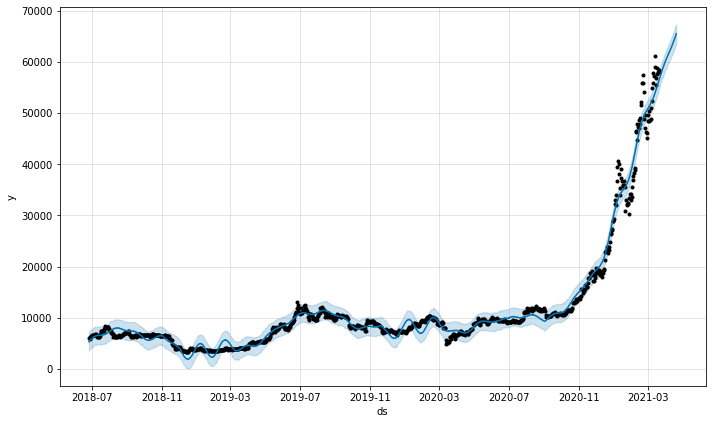

In [26]:
# Plot Predictions
model.plot(predictions).savefig('modelpredictions.png')


In [27]:
predictions_df = predictions.drop(columns=['yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'])


predictions_df['day'] = predictions_df['ds'].dt.day_name()
predictions_df['ds'] = predictions_df['ds'].dt.strftime('%Y-%m-%d')
predictions_df = predictions_df.rename(columns={"ds": "date", "trend": "BTC_price_USD"})
predictions_df.tail()

,date,BTC_price_USD,day
1025,2021-04-16,67632.250677,Friday
1026,2021-04-17,67866.718144,Saturday
1027,2021-04-18,68101.185610,Sunday
1028,2021-04-19,68335.653077,Monday
1029,2021-04-20,68570.120544,Tuesday


In [28]:
engine = create_engine(conn, echo=False)

In [29]:
predictions_df.to_sql("fb_predictions", con=engine, if_exists = 'replace', index=False, method='multi')

with engine.connect() as con:
    con.execute('ALTER TABLE "fb_predictions" ADD PRIMARY KEY ("BTC_price_USD");')

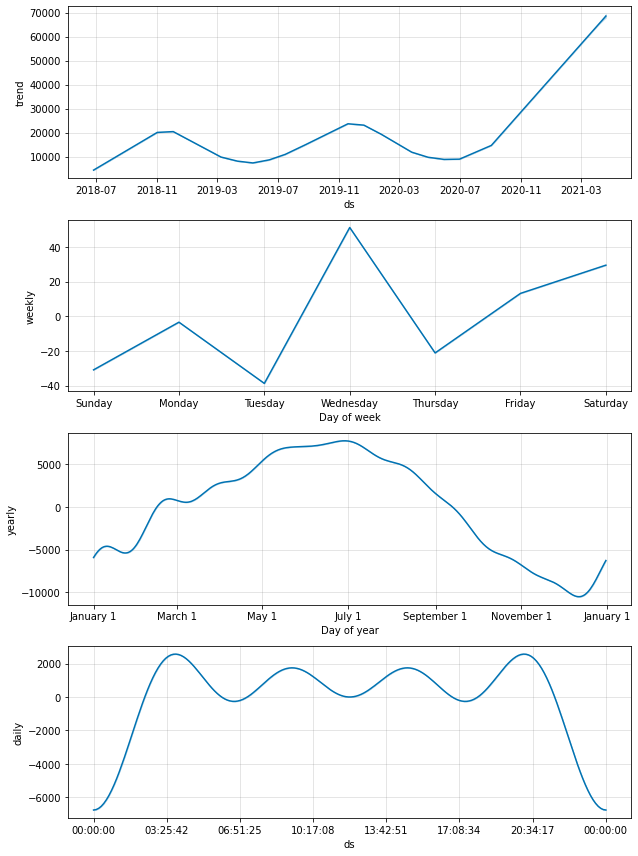

In [30]:
# Plot model components

model.plot_components(predictions).savefig('modelcomponents.png')